<a href="https://colab.research.google.com/github/aaditya9803/ml/blob/main/Stroke-prediction-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Giving access to the metroPT3.csv in google coolab
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Get the file
downloaded = drive.CreateFile({'id':'1WZT2g06H_SXu0q5PgTFXbbUVsP6MuWkU'})
downloaded.GetContentFile('dataset-stroke.csv')

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import KFold


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [44]:
train_data = pd.read_csv(('dataset-stroke.csv'), sep=',', header=0)
df = pd.DataFrame(train_data)
df.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


In [45]:
df['stroke'].value_counts()

,count
stroke,
0,4861
1,249


In [46]:
df.dropna(inplace=True)

In [47]:
df.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0


In [48]:
df.drop(columns='id', inplace=True)

In [49]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


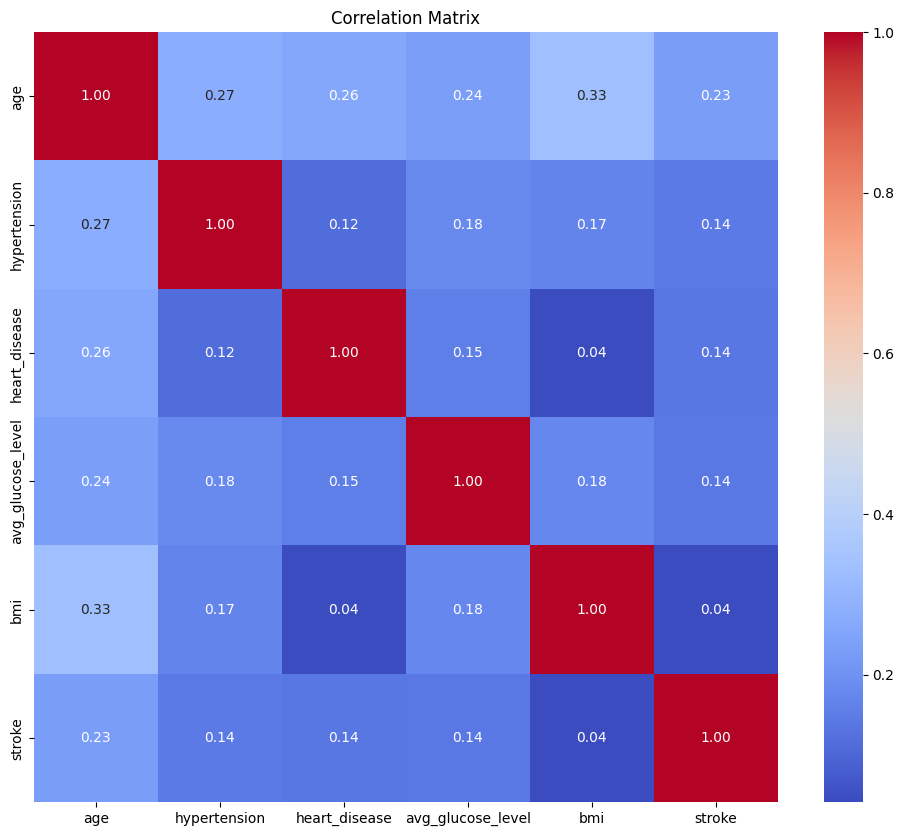

In [50]:
numerical_df = df.select_dtypes(include=['number'])
correlations = numerical_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

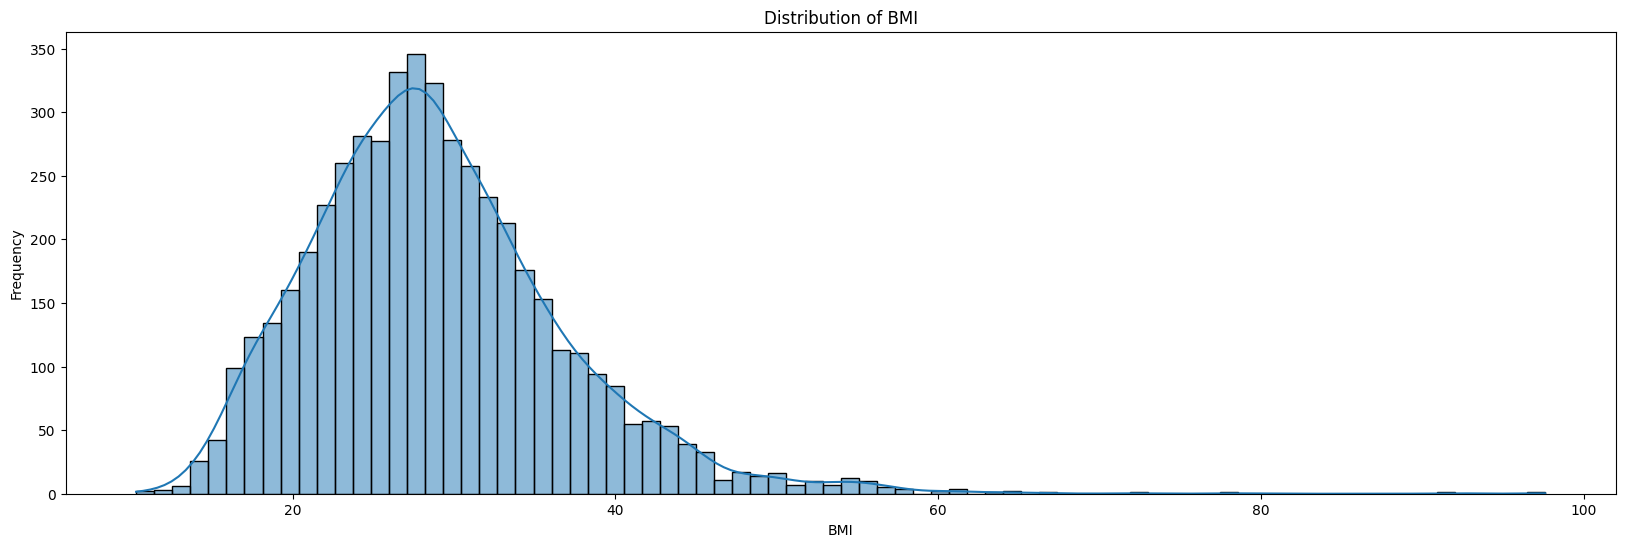

In [51]:
#Histogram
plt.figure(figsize=(20, 6))
sns.histplot(df['bmi'], kde=True)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

In [52]:
#Labelencoder
label_encoder = LabelEncoder()

columns_to_label = ['gender', 'ever_married', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for column in columns_to_label:
    df[column] = df[column].astype(str)
    df[column] = label_encoder.fit_transform(df[column])

df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.6,1,1
2,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,0,79.0,1,0,1,3,0,174.12,24.0,2,1
5,1,81.0,0,0,1,2,1,186.21,29.0,1,1


In [53]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.6,1,1
2,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,0,79.0,1,0,1,3,0,174.12,24.0,2,1
5,1,81.0,0,0,1,2,1,186.21,29.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,0,13.0,0,0,0,4,0,103.08,18.6,0,0
5106,0,81.0,0,0,1,3,1,125.20,40.0,2,0
5107,0,35.0,0,0,1,3,0,82.99,30.6,2,0
5108,1,51.0,0,0,1,2,0,166.29,25.6,1,0


In [54]:
df['stroke'].value_counts()

,count
stroke,
0,4700
1,209


In [55]:
y = df['stroke']
X = df.drop(columns='stroke')

In [61]:
X

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1,67.0,0,1,1,2,1,228.69,36.6,1
2,1,80.0,0,1,1,2,0,105.92,32.5,2
3,0,49.0,0,0,1,2,1,171.23,34.4,3
4,0,79.0,1,0,1,3,0,174.12,24.0,2
5,1,81.0,0,0,1,2,1,186.21,29.0,1
...,...,...,...,...,...,...,...,...,...,...
5104,0,13.0,0,0,0,4,0,103.08,18.6,0
5106,0,81.0,0,0,1,3,1,125.20,40.0,2
5107,0,35.0,0,0,1,3,0,82.99,30.6,2
5108,1,51.0,0,0,1,2,0,166.29,25.6,1


In [62]:
y

,stroke
0,1
2,1
3,1
4,1
5,1
...,...
5104,0
5106,0
5107,0
5108,0


In [63]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
model.fit(x_train, y_train)

# Make predictions on the test set
y_pred = model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9429735234215886


In [68]:
x_test

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
4336,1,80.0,0,1,1,2,0,125.32,32.9,0
3709,0,42.0,0,0,0,2,1,84.03,31.4,2
964,1,66.0,1,0,1,2,0,74.90,32.1,2
2647,1,29.0,0,0,1,0,1,102.40,26.9,3
3262,1,47.0,0,0,1,2,0,88.49,22.2,3
...,...,...,...,...,...,...,...,...,...,...
1022,1,22.0,0,0,0,2,0,58.38,36.0,2
205,0,78.0,0,0,1,2,1,106.74,33.0,1
3838,1,56.0,0,0,1,3,1,122.73,37.5,1
5010,0,72.0,0,0,1,3,1,74.17,35.5,1
